<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/NuGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [1]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Download the MNIST dataset

[MNIST PyTorch Docs](https://pytorch.org/vision/stable/datasets.html#mnist)

In [2]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Showing shape of train and test dataset

In [3]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


# Define a function to initialize the weights of the network


In [4]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [6]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Calculates the Eigenvalues of the Discriminator


[linalg.eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html)

In [7]:
def get_d_eigenvectors(D, G, loss, dataloader):

    num_params = sum(p.numel() for p in D.parameters())

    hv = HessianVector(model=D, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Hessian Vector Class



*   scipy.sparse.linalg.LinearOperator
  *   [Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html)



In [8]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec


# Generator and Discriminator class definition

In [9]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size    


        # self.fc1 = nn.Linear(self.input_dim, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim * self.input_size * self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x): 

        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = torch.tanh(self.fc4(x))
        # x = x.view(-1, self.output_dim, self.input_size, self.input_size)
        # return x

        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size

        # self.fc1 = nn.Linear(self.input_size * self.input_size, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x):

        # x = x.view(-1, self.input_size * self.input_size)
        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = F.dropout(x, 0.3)
        # return torch.sigmoid(self.fc4(x))

        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# Construction of GAN model

[Modifying gradients in PyTorch](https://discuss.pytorch.org/t/how-to-modify-the-gradient-manually/7483)

In [10]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #mnist_dim = data.shape[1] * data.shape[2]

        #print(data.shape)
        #self.data_width = data.shape[2]
        #self.data_height = data.shape[3]

        # initialization of the generator and discriminator
        self.G = Generator(
            input_dim=self.z_dim,       # 16
            output_dim=data.shape[1],   # 1
            input_size=self.input_size, # 28
            base_size=self.base_size    # 64
            ).cuda()

        self.D = Discriminator(
            input_dim=data.shape[1],    
            output_dim=1,
            input_size=self.input_size, 
            base_size=self.base_size
            ).cuda()

        #print("Encoder", data.shape[1], self.input_size, self.base_size)
        #self.E = encoder(input_dim=data.shape[1], output_dim=self.z_dim, input_size=self.input_size, base_size=self.base_size).cuda()
        #self.G_optimizer = optim.SGD(self.G.parameters(), lr=params['lr_g'])
        #self.D_optimizer = optim.SGD(self.D.parameters(), lr=params['lr_d'])
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        #self.E_optimizer = optim.Adam(self.E.parameters(), lr=1e-2, weight_decay=1e-4)
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        #self.smooth_loss = nn.SmoothL1Loss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()

        # Function to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        Ninner = 1
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        #self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).cuda(), torch.zeros(self.batch_size, 1).cuda()
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).fill_(0.1).type(torch.float32).cuda()
        # print(self.y_real_.shape)
        self.y_real_ = self.y_real_ + (torch.randn(self.y_real_.shape)*0.03).cuda()
        self.y_fake_ = self.y_fake_ + (torch.randn(self.y_fake_.shape)*0.03).cuda()

        print('training start!!')

        randn_var = 0.05
        randn_mean = 0.00

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()
            print("Epoch:", epoch+1)

            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # YOUR CODE HERE
                #--------------------

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                # 2. Set discriminator losses on real and fake data
                x_ = x_ + torch.normal(mean=randn_mean, std=randn_var, size=x_.shape).cuda()
                #x_ = x_ + (torch.randn(x_.shape)*randn_var + randn_mean).cuda() # Adding random noise to input images
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                z_ = z_ + torch.normal(mean=randn_mean, std=randn_var, size=z_.shape).cuda()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                # 3. Do back propagation to compute gradients
                D_loss = D_real_loss + D_fake_loss

                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.D, D_loss, self.data_loader)

                D_loss.backward()

                # if iter == 0:
                #     print("D eigen vectors:")
                #     get_eigenvectors(self.D, self.data_loader, self.BCE_loss)


                # 4. Make a step of D_optimizer
                self.D_optimizer.step()
                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake_ = self.D(G_)
                G_loss = self.BCE_loss(D_fake_, self.y_real_)
                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.G, G_loss, self.data_loader)
                # 3. Do back propagation to compute gradients
                G_loss.backward()

                # if iter == 0:
                #     print("G eigen vectors:")
                #     get_eigenvectors(self.G, self.data_loader, self.BCE_loss)

                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses
                
                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            # Visualize results
            if ((epoch + 1) % 10) == 0:
                with torch.no_grad():
                    visualize_results(self)
                #visualize_gan_optim_loss(self)

        print("Training finished!")

# Training the GAN

training start!!
Epoch: 1
Epoch: [ 1] [  50/ 200] D_loss: 1.25166869, G_loss: 0.86982656
Epoch: [ 1] [ 100/ 200] D_loss: 1.11152124, G_loss: 0.98055512
Epoch: [ 1] [ 150/ 200] D_loss: 1.05220056, G_loss: 1.14371526
Epoch: [ 1] [ 200/ 200] D_loss: 1.01928818, G_loss: 1.20790780
Epoch: 2
Epoch: [ 2] [  50/ 200] D_loss: 0.91837084, G_loss: 1.25418651
Epoch: [ 2] [ 100/ 200] D_loss: 0.90626919, G_loss: 1.24511743
Epoch: [ 2] [ 150/ 200] D_loss: 0.86421728, G_loss: 1.38800478
Epoch: [ 2] [ 200/ 200] D_loss: 0.84795469, G_loss: 1.34514558
Epoch: 3
Epoch: [ 3] [  50/ 200] D_loss: 0.81001490, G_loss: 1.37285113
Epoch: [ 3] [ 100/ 200] D_loss: 0.80385888, G_loss: 1.38463628
Epoch: [ 3] [ 150/ 200] D_loss: 0.82424021, G_loss: 1.43943346
Epoch: [ 3] [ 200/ 200] D_loss: 0.96403599, G_loss: 1.74456084
Epoch: 4
Epoch: [ 4] [  50/ 200] D_loss: 0.87603521, G_loss: 1.68660223
Epoch: [ 4] [ 100/ 200] D_loss: 0.95922279, G_loss: 1.54520595
Epoch: [ 4] [ 150/ 200] D_loss: 0.78985047, G_loss: 1.44672656
Ep

<Figure size 72x720 with 0 Axes>

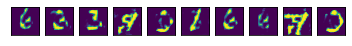

Epoch: 11
Epoch: [11] [  50/ 200] D_loss: 0.80735505, G_loss: 1.65091634
Epoch: [11] [ 100/ 200] D_loss: 0.90747362, G_loss: 1.68845928
Epoch: [11] [ 150/ 200] D_loss: 0.85878754, G_loss: 1.70784426
Epoch: [11] [ 200/ 200] D_loss: 0.89599544, G_loss: 1.49744618
Epoch: 12
Epoch: [12] [  50/ 200] D_loss: 0.79416394, G_loss: 1.59423864
Epoch: [12] [ 100/ 200] D_loss: 0.84098291, G_loss: 1.67809141
Epoch: [12] [ 150/ 200] D_loss: 0.95517373, G_loss: 2.13401580
Epoch: [12] [ 200/ 200] D_loss: 0.94102573, G_loss: 1.97042263
Epoch: 13
Epoch: [13] [  50/ 200] D_loss: 0.86548406, G_loss: 1.60913336
Epoch: [13] [ 100/ 200] D_loss: 0.82912213, G_loss: 1.60444701
Epoch: [13] [ 150/ 200] D_loss: 0.81656206, G_loss: 1.83573592
Epoch: [13] [ 200/ 200] D_loss: 0.87008309, G_loss: 1.82891667
Epoch: 14
Epoch: [14] [  50/ 200] D_loss: 0.95056152, G_loss: 1.92197394
Epoch: [14] [ 100/ 200] D_loss: 0.76426697, G_loss: 1.70935977
Epoch: [14] [ 150/ 200] D_loss: 0.79182482, G_loss: 1.54108739
Epoch: [14] [ 2

<Figure size 72x720 with 0 Axes>

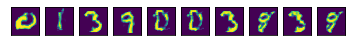

Epoch: 21
Epoch: [21] [  50/ 200] D_loss: 0.78093505, G_loss: 1.72795498
Epoch: [21] [ 100/ 200] D_loss: 0.77600169, G_loss: 1.79659677
Epoch: [21] [ 150/ 200] D_loss: 0.74958074, G_loss: 1.81679893
Epoch: [21] [ 200/ 200] D_loss: 0.86173880, G_loss: 1.92509735
Epoch: 22
Epoch: [22] [  50/ 200] D_loss: 0.75536036, G_loss: 1.81783009
Epoch: [22] [ 100/ 200] D_loss: 0.77526337, G_loss: 1.76908815
Epoch: [22] [ 150/ 200] D_loss: 0.75206316, G_loss: 1.90405440
Epoch: [22] [ 200/ 200] D_loss: 0.80783796, G_loss: 1.73923814
Epoch: 23
Epoch: [23] [  50/ 200] D_loss: 0.74208617, G_loss: 1.85834336
Epoch: [23] [ 100/ 200] D_loss: 0.84146905, G_loss: 2.02336931
Epoch: [23] [ 150/ 200] D_loss: 0.81921154, G_loss: 2.10323620
Epoch: [23] [ 200/ 200] D_loss: 0.81687152, G_loss: 1.75364625
Epoch: 24
Epoch: [24] [  50/ 200] D_loss: 0.89814699, G_loss: 2.22944260
Epoch: [24] [ 100/ 200] D_loss: 0.80140126, G_loss: 1.83278656
Epoch: [24] [ 150/ 200] D_loss: 0.77138549, G_loss: 1.82326984
Epoch: [24] [ 2

<Figure size 72x720 with 0 Axes>

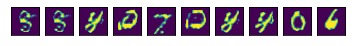

Epoch: 31
Epoch: [31] [  50/ 200] D_loss: 0.73801851, G_loss: 1.85534549
Epoch: [31] [ 100/ 200] D_loss: 0.79763180, G_loss: 1.84563255
Epoch: [31] [ 150/ 200] D_loss: 0.83842140, G_loss: 1.93557107
Epoch: [31] [ 200/ 200] D_loss: 0.79025155, G_loss: 1.90639961
Epoch: 32
Epoch: [32] [  50/ 200] D_loss: 0.72551310, G_loss: 2.03829360
Epoch: [32] [ 100/ 200] D_loss: 0.72222072, G_loss: 1.98972678
Epoch: [32] [ 150/ 200] D_loss: 0.74462563, G_loss: 2.09057593
Epoch: [32] [ 200/ 200] D_loss: 0.96065623, G_loss: 2.28777218
Epoch: 33
Epoch: [33] [  50/ 200] D_loss: 0.79958963, G_loss: 1.87180138
Epoch: [33] [ 100/ 200] D_loss: 0.77696908, G_loss: 1.89788294
Epoch: [33] [ 150/ 200] D_loss: 0.81749153, G_loss: 1.99137783
Epoch: [33] [ 200/ 200] D_loss: 0.80005920, G_loss: 1.96857655
Epoch: 34
Epoch: [34] [  50/ 200] D_loss: 0.81573492, G_loss: 1.84217453
Epoch: [34] [ 100/ 200] D_loss: 0.75799000, G_loss: 2.07252121
Epoch: [34] [ 150/ 200] D_loss: 0.76929867, G_loss: 2.05334234
Epoch: [34] [ 2

<Figure size 72x720 with 0 Axes>

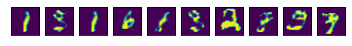

Epoch: 41
Epoch: [41] [  50/ 200] D_loss: 0.75579667, G_loss: 2.03558874
Epoch: [41] [ 100/ 200] D_loss: 0.78310323, G_loss: 1.88318932
Epoch: [41] [ 150/ 200] D_loss: 0.74753869, G_loss: 1.92867231
Epoch: [41] [ 200/ 200] D_loss: 0.83709776, G_loss: 2.41648531
Epoch: 42
Epoch: [42] [  50/ 200] D_loss: 0.74306953, G_loss: 2.00646806
Epoch: [42] [ 100/ 200] D_loss: 0.76040483, G_loss: 2.11459517
Epoch: [42] [ 150/ 200] D_loss: 0.73815191, G_loss: 1.97246563
Epoch: [42] [ 200/ 200] D_loss: 0.86296380, G_loss: 2.21461344
Epoch: 43
Epoch: [43] [  50/ 200] D_loss: 0.75493443, G_loss: 2.00738072
Epoch: [43] [ 100/ 200] D_loss: 0.72603917, G_loss: 1.90443182
Epoch: [43] [ 150/ 200] D_loss: 0.70867527, G_loss: 2.16914153
Epoch: [43] [ 200/ 200] D_loss: 0.74557471, G_loss: 2.00504255
Epoch: 44
Epoch: [44] [  50/ 200] D_loss: 0.71599674, G_loss: 1.78860819
Epoch: [44] [ 100/ 200] D_loss: 0.72494715, G_loss: 2.08436060
Epoch: [44] [ 150/ 200] D_loss: 0.72818702, G_loss: 2.04693127
Epoch: [44] [ 2

<Figure size 72x720 with 0 Axes>

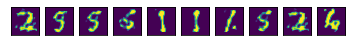

Epoch: 51
Epoch: [51] [  50/ 200] D_loss: 0.76197922, G_loss: 1.81990826
Epoch: [51] [ 100/ 200] D_loss: 0.72089612, G_loss: 2.04623365
Epoch: [51] [ 150/ 200] D_loss: 0.72334397, G_loss: 2.19421673
Epoch: [51] [ 200/ 200] D_loss: 0.77964187, G_loss: 2.21862507
Epoch: 52
Epoch: [52] [  50/ 200] D_loss: 0.74255621, G_loss: 1.93249929
Epoch: [52] [ 100/ 200] D_loss: 0.72045505, G_loss: 1.98059165
Epoch: [52] [ 150/ 200] D_loss: 0.73089063, G_loss: 1.93054402
Epoch: [52] [ 200/ 200] D_loss: 0.71451366, G_loss: 2.03597951
Epoch: 53
Epoch: [53] [  50/ 200] D_loss: 0.72146666, G_loss: 1.84723794
Epoch: [53] [ 100/ 200] D_loss: 0.73599887, G_loss: 2.09994197
Epoch: [53] [ 150/ 200] D_loss: 0.70550722, G_loss: 2.03316736
Epoch: [53] [ 200/ 200] D_loss: 0.69307387, G_loss: 2.03349257
Epoch: 54
Epoch: [54] [  50/ 200] D_loss: 0.72072184, G_loss: 2.09381771
Epoch: [54] [ 100/ 200] D_loss: 0.72601539, G_loss: 2.21723175
Epoch: [54] [ 150/ 200] D_loss: 0.75389123, G_loss: 1.94864655
Epoch: [54] [ 2

<Figure size 72x720 with 0 Axes>

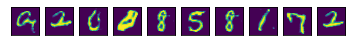

Epoch: 61
Epoch: [61] [  50/ 200] D_loss: 0.72918236, G_loss: 2.25346112
Epoch: [61] [ 100/ 200] D_loss: 0.74377406, G_loss: 1.94908142
Epoch: [61] [ 150/ 200] D_loss: 0.70894170, G_loss: 1.98462546
Epoch: [61] [ 200/ 200] D_loss: 0.70691603, G_loss: 2.14773536
Epoch: 62
Epoch: [62] [  50/ 200] D_loss: 0.74278009, G_loss: 1.92706263
Epoch: [62] [ 100/ 200] D_loss: 0.72092819, G_loss: 2.22959590
Epoch: [62] [ 150/ 200] D_loss: 0.71085042, G_loss: 2.22431254
Epoch: [62] [ 200/ 200] D_loss: 0.71563876, G_loss: 2.25161576
Epoch: 63
Epoch: [63] [  50/ 200] D_loss: 0.71366501, G_loss: 2.06857109
Epoch: [63] [ 100/ 200] D_loss: 0.72027987, G_loss: 2.21207595
Epoch: [63] [ 150/ 200] D_loss: 0.73738885, G_loss: 2.04342628
Epoch: [63] [ 200/ 200] D_loss: 0.81315923, G_loss: 2.34299302
Epoch: 64
Epoch: [64] [  50/ 200] D_loss: 0.72992563, G_loss: 1.97732484
Epoch: [64] [ 100/ 200] D_loss: 0.72292203, G_loss: 1.98452961
Epoch: [64] [ 150/ 200] D_loss: 0.71116722, G_loss: 1.95222819
Epoch: [64] [ 2

<Figure size 72x720 with 0 Axes>

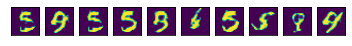

Epoch: 71
Epoch: [71] [  50/ 200] D_loss: 0.70469999, G_loss: 2.04619312
Epoch: [71] [ 100/ 200] D_loss: 0.72994792, G_loss: 1.91499603
Epoch: [71] [ 150/ 200] D_loss: 0.75803155, G_loss: 2.15268612
Epoch: [71] [ 200/ 200] D_loss: 0.74397635, G_loss: 2.15323377
Epoch: 72
Epoch: [72] [  50/ 200] D_loss: 0.69594753, G_loss: 2.03853512
Epoch: [72] [ 100/ 200] D_loss: 0.71083736, G_loss: 2.27410555
Epoch: [72] [ 150/ 200] D_loss: 0.71781790, G_loss: 2.02499151
Epoch: [72] [ 200/ 200] D_loss: 0.70628273, G_loss: 1.87906909
Epoch: 73
Epoch: [73] [  50/ 200] D_loss: 0.71220517, G_loss: 2.09059668
Epoch: [73] [ 100/ 200] D_loss: 0.69634736, G_loss: 2.12738848
Epoch: [73] [ 150/ 200] D_loss: 0.69942361, G_loss: 1.97408712
Epoch: [73] [ 200/ 200] D_loss: 0.70470506, G_loss: 2.27499413
Epoch: 74
Epoch: [74] [  50/ 200] D_loss: 0.72201407, G_loss: 2.20653844
Epoch: [74] [ 100/ 200] D_loss: 0.75507891, G_loss: 2.03033042
Epoch: [74] [ 150/ 200] D_loss: 0.71321309, G_loss: 2.17979288
Epoch: [74] [ 2

<Figure size 72x720 with 0 Axes>

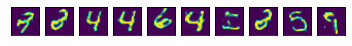

Epoch: 81
Epoch: [81] [  50/ 200] D_loss: 0.73454303, G_loss: 2.18610740
Epoch: [81] [ 100/ 200] D_loss: 0.72439551, G_loss: 2.07793880
Epoch: [81] [ 150/ 200] D_loss: 0.72361588, G_loss: 2.26253223
Epoch: [81] [ 200/ 200] D_loss: 0.70845211, G_loss: 2.16727352
Epoch: 82
Epoch: [82] [  50/ 200] D_loss: 0.70010567, G_loss: 2.19534826
Epoch: [82] [ 100/ 200] D_loss: 0.80134690, G_loss: 2.89809823
Epoch: [82] [ 150/ 200] D_loss: 0.78196788, G_loss: 2.25029087
Epoch: [82] [ 200/ 200] D_loss: 0.69633251, G_loss: 1.94121420
Epoch: 83
Epoch: [83] [  50/ 200] D_loss: 0.69215029, G_loss: 2.03789473
Epoch: [83] [ 100/ 200] D_loss: 0.68409806, G_loss: 2.01791620
Epoch: [83] [ 150/ 200] D_loss: 0.72266090, G_loss: 2.29759884
Epoch: [83] [ 200/ 200] D_loss: 0.70712948, G_loss: 2.11310434
Epoch: 84
Epoch: [84] [  50/ 200] D_loss: 0.75450701, G_loss: 2.27236009
Epoch: [84] [ 100/ 200] D_loss: 0.72298181, G_loss: 2.08928990
Epoch: [84] [ 150/ 200] D_loss: 0.74288213, G_loss: 2.20288777
Epoch: [84] [ 2

<Figure size 72x720 with 0 Axes>

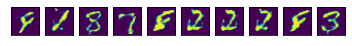

Epoch: 91
Epoch: [91] [  50/ 200] D_loss: 0.73791254, G_loss: 2.02789545
Epoch: [91] [ 100/ 200] D_loss: 0.72559476, G_loss: 2.01667929
Epoch: [91] [ 150/ 200] D_loss: 0.77072483, G_loss: 2.06827068
Epoch: [91] [ 200/ 200] D_loss: 0.74460584, G_loss: 2.24686980
Epoch: 92
Epoch: [92] [  50/ 200] D_loss: 0.69659960, G_loss: 2.12703943
Epoch: [92] [ 100/ 200] D_loss: 0.71787965, G_loss: 2.14341402
Epoch: [92] [ 150/ 200] D_loss: 0.69480550, G_loss: 1.95878673
Epoch: [92] [ 200/ 200] D_loss: 0.75704712, G_loss: 1.95756042
Epoch: 93
Epoch: [93] [  50/ 200] D_loss: 0.70403433, G_loss: 1.96915734
Epoch: [93] [ 100/ 200] D_loss: 0.70495784, G_loss: 2.16837907
Epoch: [93] [ 150/ 200] D_loss: 0.70695412, G_loss: 2.16730261
Epoch: [93] [ 200/ 200] D_loss: 0.71160257, G_loss: 2.20801759
Epoch: 94
Epoch: [94] [  50/ 200] D_loss: 0.68880355, G_loss: 1.98345184
Epoch: [94] [ 100/ 200] D_loss: 0.72939420, G_loss: 2.20517778
Epoch: [94] [ 150/ 200] D_loss: 0.71702600, G_loss: 2.24152422
Epoch: [94] [ 2

<Figure size 72x720 with 0 Axes>

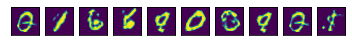

Epoch: 101
Epoch: [101] [  50/ 200] D_loss: 0.72605371, G_loss: 2.32840133
Epoch: [101] [ 100/ 200] D_loss: 0.69274622, G_loss: 1.87258184
Epoch: [101] [ 150/ 200] D_loss: 0.72299170, G_loss: 2.27851701
Epoch: [101] [ 200/ 200] D_loss: 0.70058280, G_loss: 2.08578658
Epoch: 102
Epoch: [102] [  50/ 200] D_loss: 0.69431776, G_loss: 2.28349233
Epoch: [102] [ 100/ 200] D_loss: 0.70837259, G_loss: 2.06164384
Epoch: [102] [ 150/ 200] D_loss: 0.71210128, G_loss: 2.11360407
Epoch: [102] [ 200/ 200] D_loss: 0.71406472, G_loss: 2.41532350
Epoch: 103
Epoch: [103] [  50/ 200] D_loss: 0.74283373, G_loss: 2.37222910
Epoch: [103] [ 100/ 200] D_loss: 0.73123729, G_loss: 1.90196860
Epoch: [103] [ 150/ 200] D_loss: 0.77912253, G_loss: 2.09257746
Epoch: [103] [ 200/ 200] D_loss: 0.71782672, G_loss: 2.10209060
Epoch: 104
Epoch: [104] [  50/ 200] D_loss: 0.71351540, G_loss: 2.25145912
Epoch: [104] [ 100/ 200] D_loss: 0.70397019, G_loss: 2.29187584
Epoch: [104] [ 150/ 200] D_loss: 0.69703335, G_loss: 2.09116

<Figure size 72x720 with 0 Axes>

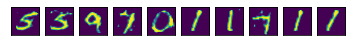

Epoch: 111
Epoch: [111] [  50/ 200] D_loss: 0.76520407, G_loss: 1.84678638
Epoch: [111] [ 100/ 200] D_loss: 0.68363279, G_loss: 1.96033514
Epoch: [111] [ 150/ 200] D_loss: 0.69711560, G_loss: 1.96552658
Epoch: [111] [ 200/ 200] D_loss: 0.68766284, G_loss: 2.10190129
Epoch: 112
Epoch: [112] [  50/ 200] D_loss: 0.68876529, G_loss: 2.21069884
Epoch: [112] [ 100/ 200] D_loss: 0.72323346, G_loss: 2.02842951
Epoch: [112] [ 150/ 200] D_loss: 0.69505435, G_loss: 2.16571379
Epoch: [112] [ 200/ 200] D_loss: 0.69933939, G_loss: 2.15620542
Epoch: 113
Epoch: [113] [  50/ 200] D_loss: 0.72644812, G_loss: 2.09330821
Epoch: [113] [ 100/ 200] D_loss: 0.70653450, G_loss: 2.00780702
Epoch: [113] [ 150/ 200] D_loss: 0.71803707, G_loss: 1.97700953
Epoch: [113] [ 200/ 200] D_loss: 0.69397068, G_loss: 2.29055071
Epoch: 114
Epoch: [114] [  50/ 200] D_loss: 0.70856953, G_loss: 1.93398583
Epoch: [114] [ 100/ 200] D_loss: 0.68389869, G_loss: 2.00403643
Epoch: [114] [ 150/ 200] D_loss: 0.72184324, G_loss: 2.17476

<Figure size 72x720 with 0 Axes>

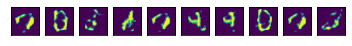

Epoch: 121
Epoch: [121] [  50/ 200] D_loss: 0.78101540, G_loss: 2.66959763
Epoch: [121] [ 100/ 200] D_loss: 0.69594812, G_loss: 2.15591812
Epoch: [121] [ 150/ 200] D_loss: 0.73252141, G_loss: 2.10146499
Epoch: [121] [ 200/ 200] D_loss: 0.70145535, G_loss: 1.88645899
Epoch: 122
Epoch: [122] [  50/ 200] D_loss: 0.71142840, G_loss: 1.90510499
Epoch: [122] [ 100/ 200] D_loss: 0.74994785, G_loss: 2.28381681
Epoch: [122] [ 150/ 200] D_loss: 0.68156022, G_loss: 2.01181865
Epoch: [122] [ 200/ 200] D_loss: 0.67878425, G_loss: 2.16155076
Epoch: 123
Epoch: [123] [  50/ 200] D_loss: 0.69268477, G_loss: 1.89218903
Epoch: [123] [ 100/ 200] D_loss: 0.68935090, G_loss: 2.24271941
Epoch: [123] [ 150/ 200] D_loss: 0.69805670, G_loss: 2.08211470
Epoch: [123] [ 200/ 200] D_loss: 0.67737043, G_loss: 2.10708165
Epoch: 124
Epoch: [124] [  50/ 200] D_loss: 0.69149238, G_loss: 2.17389965
Epoch: [124] [ 100/ 200] D_loss: 0.69248462, G_loss: 2.06904268
Epoch: [124] [ 150/ 200] D_loss: 0.70325786, G_loss: 2.28042

<Figure size 72x720 with 0 Axes>

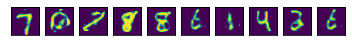

Epoch: 131
Epoch: [131] [  50/ 200] D_loss: 0.69199216, G_loss: 2.08030844
Epoch: [131] [ 100/ 200] D_loss: 0.69768846, G_loss: 2.14297128
Epoch: [131] [ 150/ 200] D_loss: 0.69971102, G_loss: 2.04523516
Epoch: [131] [ 200/ 200] D_loss: 0.68947762, G_loss: 2.03693891
Epoch: 132
Epoch: [132] [  50/ 200] D_loss: 0.79745340, G_loss: 2.47731209
Epoch: [132] [ 100/ 200] D_loss: 0.68149984, G_loss: 2.04626846
Epoch: [132] [ 150/ 200] D_loss: 0.69171292, G_loss: 2.11889625
Epoch: [132] [ 200/ 200] D_loss: 0.69890201, G_loss: 2.15223122
Epoch: 133
Epoch: [133] [  50/ 200] D_loss: 0.68824285, G_loss: 2.10399461
Epoch: [133] [ 100/ 200] D_loss: 0.70656395, G_loss: 1.99718511
Epoch: [133] [ 150/ 200] D_loss: 0.67829025, G_loss: 2.04763722
Epoch: [133] [ 200/ 200] D_loss: 0.71959847, G_loss: 2.06456590
Epoch: 134
Epoch: [134] [  50/ 200] D_loss: 0.71847409, G_loss: 2.14841509
Epoch: [134] [ 100/ 200] D_loss: 0.68925893, G_loss: 2.04659295
Epoch: [134] [ 150/ 200] D_loss: 0.68454945, G_loss: 2.09641

<Figure size 72x720 with 0 Axes>

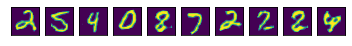

Epoch: 141
Epoch: [141] [  50/ 200] D_loss: 0.68051314, G_loss: 2.39793515
Epoch: [141] [ 100/ 200] D_loss: 0.69178462, G_loss: 2.15976667
Epoch: [141] [ 150/ 200] D_loss: 0.70268273, G_loss: 1.99186003
Epoch: [141] [ 200/ 200] D_loss: 0.74762130, G_loss: 1.96621442
Epoch: 142
Epoch: [142] [  50/ 200] D_loss: 0.69445300, G_loss: 2.06659412
Epoch: [142] [ 100/ 200] D_loss: 0.70094335, G_loss: 2.17411900
Epoch: [142] [ 150/ 200] D_loss: 0.70622289, G_loss: 2.16862345
Epoch: [142] [ 200/ 200] D_loss: 0.68987441, G_loss: 2.18360209
Epoch: 143
Epoch: [143] [  50/ 200] D_loss: 0.69319797, G_loss: 2.18702817
Epoch: [143] [ 100/ 200] D_loss: 0.69906783, G_loss: 1.99159515
Epoch: [143] [ 150/ 200] D_loss: 0.69206393, G_loss: 1.93210948
Epoch: [143] [ 200/ 200] D_loss: 0.68651533, G_loss: 2.22458220
Epoch: 144
Epoch: [144] [  50/ 200] D_loss: 0.69977158, G_loss: 2.23377824
Epoch: [144] [ 100/ 200] D_loss: 0.74292731, G_loss: 2.23682451
Epoch: [144] [ 150/ 200] D_loss: 0.68423986, G_loss: 2.18119

<Figure size 72x720 with 0 Axes>

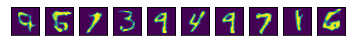

Training finished!


In [11]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':150}
params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)
gan.train()